In [1]:
# Import required libraries for image preprocessing, model loading, prediction, and plotting
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from keras.applications.xception import Xception
from keras.models import load_model
from pickle import load
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
import argparse
from tensorflow.keras.layers import Input, Dense, LSTM, Embedding, Dropout
from tensorflow.keras.layers import add
from tensorflow.keras.models import Model

In [2]:
# # Argument parser to get image path from command line
# ap = argparse.ArgumentParser()
# ap.add_argument('-i', '--image', required=True, help="Image Path")
# args = vars(ap.parse_args())

img_path = 'D:\\ClassAIML\\DLWithPython\\ClassNB\\Projects\\ClassProj2\\Flicker8k_Dataset\\123889082_d3751e0350.jpg'

In [3]:
# Function to extract features from the input image using Xception model
def extract_features(filename, model):
    try:
        image = Image.open(filename)
    except:
        print("ERROR: Couldn't open image! Make sure the image path and extension is correct")
    
    # Resize and normalize the image
    image = image.resize((299, 299))
    image = np.array(image)

    # If image has 4 channels (RGBA), keep only RGB
    if image.shape[2] == 4:
        image = image[..., :3]
    
    # Expand dimensions to match model input shape
    image = np.expand_dims(image, axis=0)
    
    # Normalize to [-1, 1] as expected by Xception
    image = image / 127.5
    image = image - 1.0

    # Extract features using the pre-trained CNN
    feature = model.predict(image)
    return feature

In [4]:
# Map predicted word index back to actual word using tokenizer
def word_for_id(integer, tokenizer):
    for word, index in tokenizer.word_index.items():
        if index == integer:
            return word
    return None

In [5]:
# Generate caption for the image using trained model
def generate_desc(model, tokenizer, photo, max_length):
    in_text = 'start'
    for i in range(max_length):
        # Convert current text to sequence of integers
        sequence = tokenizer.texts_to_sequences([in_text])[0]
        sequence = pad_sequences([sequence], maxlen=max_length)
        
        # Predict the next word in the sequence
        pred = model.predict([photo, sequence], verbose=0)
        pred = np.argmax(pred)
        
        # Convert predicted index to word
        word = word_for_id(pred, tokenizer)
        if word is None:
            break
        
        # Append word to current text
        in_text += ' ' + word

        # Stop if 'end' token is generated
        if word == 'end':
            break
    return in_text

In [6]:
from keras.utils import plot_model

In [7]:
# Define the same model architecture used during training
def define_model(vocab_size, max_length):
    # Image input branch
    inputs1 = Input(shape=(2048,), name='input_1')
    fe1 = Dropout(0.5)(inputs1)
    fe2 = Dense(256, activation='relu')(fe1)

    # Text input branch
    inputs2 = Input(shape=(max_length,), name='input_2')
    se1 = Embedding(vocab_size, 256, mask_zero=True)(inputs2)
    se2 = Dropout(0.5)(se1)
    se3 = LSTM(256)(se2)

    # Combine image and text branches
    decoder1 = add([fe2, se3])
    decoder2 = Dense(256, activation='relu')(decoder1)
    outputs = Dense(vocab_size, activation='softmax')(decoder2)

    # Create the model
    model = Model(inputs=[inputs1, inputs2], outputs=outputs)
    model.compile(loss='categorical_crossentropy', optimizer='adam')

    # Print summary and save model structure diagram
    print(model.summary())
    plot_model(model, to_file='model.png', show_shapes=True)

    return model

In [8]:
# Set max caption length and load tokenizer
max_length = 32
tokenizer = load(open("tokenizer.p", "rb"))
vocab_size = len(tokenizer.word_index) + 1

In [9]:
# Define model architecture and load trained weights
model = define_model(vocab_size, max_length)
model.load_weights('D://ClassAIML//DLWithPython//ClassNB//Projects//ClassProj2//avbmodels//model_9.h5')

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 32)]         0           []                               
                                                                                                  
 input_1 (InputLayer)           [(None, 2048)]       0           []                               
                                                                                                  
 embedding (Embedding)          (None, 32, 256)      1939712     ['input_2[0][0]']                
                                                                                                  
 dropout (Dropout)              (None, 2048)         0           ['input_1[0][0]']                
                                                                                              

In [10]:
# Load pre-trained Xception model for feature extraction
xception_model = Xception(include_top=False, pooling="avg")

In [11]:
# Extract features from input image
photo = extract_features(img_path, xception_model)

1/1 [==============================] - 2s 2s/step


In [12]:
# Load the image for display
img = Image.open(img_path)

In [13]:
# Generate caption from image
description = generate_desc(model, tokenizer, photo, max_length)




start black dog is on the the the the the the the the the black black black dog end


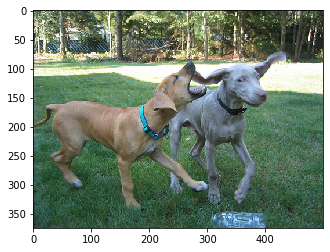

In [14]:
# Output the generated caption and display the image
print("\n\n")
print(description)
plt.imshow(img)